# Elliptical Slice Sampling without mean shifting in Tensorflow
This code is largely based on the example code found [here](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/mcmc/EllipticalSliceSampler). The credit for the example used should go to [Viking Penguin](https://www.youtube.com/watch?v=HfzyuD9_gmk), code can be found [here](https://gist.github.com/adiehl96/d586d13ac47d7f2a3e98142b2c436ef5).

# Assumptions
* The sampler assumes that the prior is a gaussian (This can be seen in the sampling step where we have to sample from a multivariate gaussian distribution).
* The sampler assumes a prior with a zero mean, as the mean is not mentioned in this implementation.

Sample mean:  tf.Tensor(2.0122658042521224, shape=(), dtype=float64)
Sample Std:  tf.Tensor(0.8869796637564445, shape=(), dtype=float64)


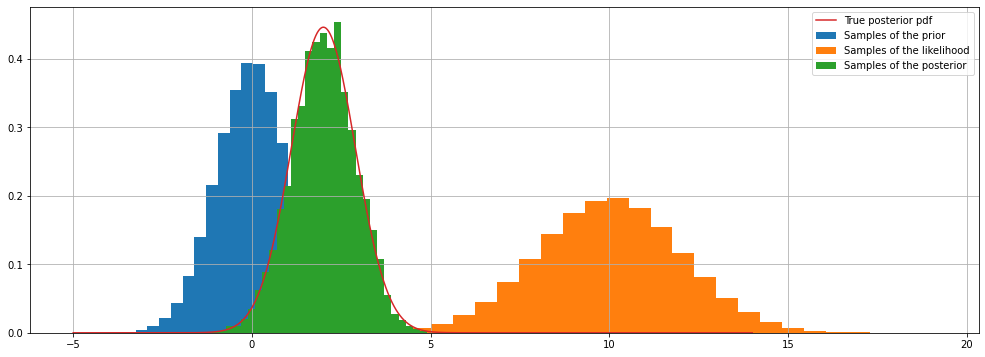

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

tfd = tfp.distributions

dtype = np.float64

seed = 1234

prior_mean = dtype(0.)
prior_variance = dtype(1.)
likelihood_mean = dtype(10.)
likelihood_variance = dtype(2.)
posterior_mean = ((prior_variance**-2)*prior_mean + (likelihood_variance**-2)*likelihood_mean) / (prior_variance**-2 + likelihood_variance**-2)
posterior_mean = dtype(posterior_mean)
posterior_variance = np.sqrt((prior_variance**2 * likelihood_variance**2) / (prior_variance**2 + likelihood_variance**2))
posterior_variance = dtype(posterior_variance)

normal_sampler_fn = lambda seed: tfd.Normal(
    loc=dtype(0), scale=prior_variance).sample(seed=seed)

log_likelihood_fn = lambda f: tf.reduce_sum(tfd.Normal(likelihood_mean, likelihood_variance).log_prob(f))

kernel = tfp.experimental.mcmc.EllipticalSliceSampler(
    normal_sampler_fn=normal_sampler_fn,
    log_likelihood_fn=log_likelihood_fn)

samples = tfp.mcmc.sample_chain(
    num_results=int(10000),
    current_state=normal_sampler_fn(seed),
    kernel=kernel,
    num_burnin_steps=1000,
    trace_fn=None,
    parallel_iterations=1,
    seed=seed)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
  tf.reduce_mean(tf.math.squared_difference(samples, sample_mean),axis=0))

print("Sample mean: ", sample_mean)
print("Sample Std: ", sample_std)

# Visualize the samples and compare to the true "posterior"
plt.figure(figsize=(17,6))
plt.hist(np.random.normal(prior_mean, prior_variance, size=200000), bins=30, density=True, label = "Samples of the prior")
plt.hist(np.random.normal(likelihood_mean, likelihood_variance, size=200000), bins=30, density=True, label = "Samples of the likelihood")

plt.hist(samples, bins=30, density=True, label = "Samples of the posterior")

r = np.linspace(-5., 14., num=1000)
plt.plot(r, norm.pdf(r, posterior_mean, posterior_variance), label = "True posterior pdf")
plt.grid()
plt.legend()
plt.show()